# Overview
This notebook has to main parts. The first part will guide you through the "compact" build process of the model and it's surroundings. The second part will go through the calculation process step by step. 

# Part 1 - Built the Model and Learning Process

## Dependencies

### Optional: GDrive connection
If you want to run this on Google Colab, you can connect the notebook to your Google Drive to access training data from there. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

### Libraries and Parameters

In [18]:
import torch
import torch.nn as nn
import mmap
import time
import random
import pickle
from torchinfo import summary
import matplotlib.pyplot as plt

source_data_path = "./"
source_data = "text.txt"
model_export = "model.pth"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

device = "mps" if torch.backends.mps.is_available() else device

print(f'Running on `{device}`')

batch_size = 8 # how many blocks per batch
sequence_length = 8 # length of sequence of tokens, how many chars/words per sequence 
epochs = 10 # training iterations
learning_rate = 0.0001 # step size per epoch
embedding_size = 128 # the size of the embedding vectors that each token will be assigned to, like if set to 128, one token would be embedded into a vector of size 128
num_transformer_blocks = 4 # amount of transformer blocks
num_heads = 4 # amount of attention heads (per block), should be bigger as embedding_size, see next line
attention_head_size = embedding_size // num_heads # dont change this, defining it here for better readability, using this operation simplifies process
dropout_rate = 0.2 # how many nodes to drop per each epoch
hidden_units_factor = 4 # how many hidden units for the sequential layer stack inside Feedforward-Module, using a factor here, will be multiplied with embedding_size, increases the models capability to process more complex patterns, also increases computational power
train_split = 0.8 # test and train dataset split rate

losses = {} # for statistical reasons

Running on `mps`


## Data
I am giving you two options here: Either create a dummy data set with a lot of simple repetitions. This allows the model to learn fast. Or choose a real world example and skip the "Dummy Data part". 

If you are looking for better results, you may refer to e.g. **OpenWebText** or other available data sets. 

Also please note, that this basic implementation uses chars as token. If you want to tokenize on a word-base, you may implement a more sophisticated tokenizer.

#### Dummy Data

In [5]:
sentence = "Hello World! Hello World! Hello World! \n"
f_dummy_data = open(f"{source_data_path}/{source_data}", 'w')
f_dummy_data.write(sentence * 1000)
f_dummy_data.close()

#### Prepare
We are going to read the data (which can be found in ```source_data``` as defined on top) and split it into two parts: **Training** data and **testing** data. 

Next we get a list of all used `chars` and create two tables for encoding and decoding(`char_table` and `reverse_char_table`) text into vector of integers. The `vocab_size` shows the amount of different chars in the text.

In [6]:
chars = ""
full_text = []
source_data_train = f"train_{source_data}"
source_data_test = f"test_{source_data}"

f_full_text = open(f"{source_data_path}/{source_data}", "r")
f_training_text = open(f"{source_data_path}/{source_data_train}", 'w')
f_test_test = open(f"{source_data_path}/{source_data_test}", 'w')

for line in f_full_text:
  r = random.random()
  full_text.append(line)
  if (0.0 <=  r <= train_split):
    f_training_text.write(line)
  else:
    f_test_test.write(line)

f_full_text.close()
f_training_text.close()
f_test_test.close()

chars = sorted(list(set(' '.join(full_text))))
char_table = {char:index for index,char in enumerate(chars)}
reverse_char_table = {index:char for index,char in enumerate(char_table)}

vocab_size = len(chars)
del full_text

print(f'Vocabulary size is {vocab_size}')

Vocabulary size is 10


## Helper Functions

We will create four functions:
`encode()` and `decode()` will allow us to convert text to a vector of integers and back. 

`get_batch` and `get_random_chunk` will randomly read text chunks from our **training** and **testing** data set.

`get_random_chunk` returns one big block of from a random position in the source file.

`get_batch` will dismantle the block into smaller sequences with a length of `sequence_length`. It will split the data into train and test data sets. The test data set is shifted by one char.

In [7]:
def encode(char_table: list, text: str = None):
  return [char_table[char] for char in text]

def decode(char_table: list, numbers: list = []):
  return ''.join([char_table[index] for index in numbers])

def get_random_chunk(split):
    filename = f"{source_data_path}/{source_data_train}" if split == 'train' else f"{source_data_path}/{source_data_test}"
    with open(filename, 'r') as f:
        with mmap.mmap(f.fileno(), 0, access=mmap.ACCESS_READ) as mm:
            # Determine the file size and a random position to start reading
            file_size = len(mm)
            start_pos = random.randint(0, (file_size) - sequence_length * batch_size)

            # Seek to the random position and read data binary
            mm.seek(start_pos)
            raw_data = mm.read(sequence_length * batch_size - 1)

            # Decode the block to a string, ignoring any invalid byte sequences
            data = raw_data.decode('utf-8', errors='ignore').replace('\r', '')

            # encode to torch tensor using char table
            encoded_data = torch.tensor(encode(char_table = char_table, text = data), dtype=torch.long)

    return encoded_data


def get_batch(split):
    
    encoded_data = get_random_chunk(split)
    random_block_start_indices = torch.randint(len(encoded_data) - sequence_length, (batch_size,))

    input_sequences = torch.stack([encoded_data[index:index + sequence_length] for index in random_block_start_indices])
    target_sequences = torch.stack([encoded_data[index + 1:index + sequence_length + 1] for index in random_block_start_indices])

    return input_sequences.to(device), target_sequences.to(device)

The following part just tests encoding and decoding feature:

In [8]:
text = 'Hello World!'
encoded_text = encode(char_table, 'Hello World!')
decoded_text = decode(reverse_char_table, encoded_text)
print(f'Encoding `{text} ` to  `{encoded_text} ` and back to  `{decoded_text} `')

Encoding `Hello World! ` to  `[3, 6, 7, 7, 8, 1, 4, 8, 9, 7, 5, 2] ` and back to  `Hello World! `


## Model Classes
This part defines the model structure. I am referring to the Multi-Head attention approach. I am not going into detail about mathematics. 

This is the comprised structure:

- create **token** and **position embeddings** of the input text and pass them to
- a sequential layer stack of `num_blocks` blocks 
  - pass embeddings to one **MultiHeadAttention** per block consisting of `num_heads` of heads for **self-attention calculation**
    - pass result to a linear **projection layer**
    - apply dropout of `dropout_rate` nodes 
  - pass results to the first **normalisation layer**
  - pass results to a **feed forward layer**, which consists of a sequential layer stack of
    - a linear layer
    - a non-linear ReLU layer
    - a linear layer
    - another dropout layer
  - pass results to the second **normalisation layer**
- pass results to another **normalisation layer**
- pass results to a final **linear layer**
- reset the weights

In [42]:
class Head(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.linear_layer_keys = nn.Linear(in_features=embedding_size, out_features=attention_head_size, bias=False)
        self.linear_layer_queries = nn.Linear(in_features=embedding_size, out_features=attention_head_size, bias=False)
        self.linear_layer_values = nn.Linear(in_features=embedding_size, out_features=attention_head_size, bias=False)
        
        # lower triangular matrix
        # .register_buffer register "not trainable parameters" for the model
        # .tril() takes a tensor and changes all values above a diagonal (top left to bottom right) to 0
        self.register_buffer('tril', torch.tril(torch.ones(sequence_length, sequence_length))) 

        # forget nodes
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X_embeddings):
        
        # input shape (batch_size, sequence_length (time steps), number of features (channels))
        # output shape (batch_size, sequence_length (time steps), head_size)

        keys = self.linear_layer_keys(X_embeddings)
        queries = self.linear_layer_queries(X_embeddings)
        values = self.linear_layer_values(X_embeddings)

        # compute attention scores ("affinities")
        
        # the core of this model: the attention mechanism
        # scaled dot product attention by matrix multiplication and scaling the result using square root of the head_size
        # we could either divide by square root of head size or multiple by inverse square root of head size, result is the same
        scaled_attention_scores = queries @ keys.transpose(-2,-1) * keys.shape[-1] ** -0.5
        
        # "sort out" all the weights above the diagonale to make sure a token depends/attends on/to previous tokens
        causal_attention_scores = scaled_attention_scores.masked_fill(self.tril[:sequence_length, :sequence_length] == 0, float('-inf'))
        
        # normalize probabilities
        weights = torch.softmax(causal_attention_scores, dim=-1)
        
        # forget some weights
        weights = self.dropout(weights)

        # perform the weighted aggregation of the values
        weighted_values = weights @ values
        return weighted_values

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel, in contrast to the "classical" encoder-decoder attention """

    def __init__(self):
        super().__init__()
        
        self.heads = nn.ModuleList([Head() for head in range(num_heads)])
        self.projections = nn.Linear(attention_head_size * num_heads, embedding_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X_embeddings):
        weighted_values = torch.cat([head(X_embeddings) for head in self.heads], dim=-1) 
        weighted_values = self.dropout(self.projections(weighted_values))
        return weighted_values

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = hidden_units_factor * embedding_size),
            nn.ReLU(),
            nn.Linear(in_features = hidden_units_factor * embedding_size, out_features = embedding_size),
            nn.Dropout(dropout_rate),
        )

    def forward(self, X):
        return self.linear_layer_stack(X)

class TransformerBlock(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.self_attention_layer = MultiHeadAttention()
        self.layer_normalisation_1 = nn.LayerNorm(embedding_size)
        
        self.feed_forward_layer = FeedForward()
        self.layer_normalisation_2 = nn.LayerNorm(embedding_size)

    def forward(self, X_embeddings):
        
        y = self.self_attention_layer(X_embeddings) # relationships and interactions, create a context
        X_embeddings = self.layer_normalisation_1(X_embeddings + y) # residual connection to mitigate the vanishing gradient
        
        y = self.feed_forward_layer(X_embeddings) # refine individual characteristics
        X_embeddings = self.layer_normalisation_2(X_embeddings + y) # residual connection to mitigate the vanishing gradient
        
        return X_embeddings

class GPTLanguageModel(nn.Module):
    
    def __init__(self, vocab_size):
        super().__init__()
        
        self.token_embedding_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size)
        self.position_embedding_table = nn.Embedding(num_embeddings=sequence_length, embedding_dim=embedding_size)
        
        self.blocks = nn.Sequential(*[TransformerBlock() for layer in range(num_transformer_blocks)])
        self.layer_normalisation = nn.LayerNorm(embedding_size)
        self.final_layer = nn.Linear(embedding_size, vocab_size)

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, X_batch):
        # X_batch - a batch of blocks (aka sequences), each containing chars

        # from a simple encoding like [0] (for `A`) to an embedding vector where each token is represented by it's own vector of size "embedding_size" like [0.0265, 0.0334]
        X_token_embeddings = self.token_embedding_table(X_batch) 
        
        # sequence_length - Block Size/Time Steps - how many chars within a block (aka sequence)
        X_position_embeddings = self.position_embedding_table(torch.arange(sequence_length, device = device))
        
        X_embeddings = X_token_embeddings + X_position_embeddings
        
        labels = self.blocks(X_embeddings) # (B,T,C)
        labels = self.layer_normalisation(labels) # (B,T,C)
        labels = self.final_layer(labels) # (Batch Size, Block Size, Vocab Size)

        return labels

    def generate(self, context, max_new_tokens):
        # context is encoded prompt as a tensor of floats with shape = (Batch Size, Block Size Dummy) 
        for new_token in range(max_new_tokens):
            # get block from context
            block = context[:, -sequence_length:]
            # let the model calculate prediction logits
            y_logits = self.forward(block)
            # focus only on the last time step
            y_logits = y_logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            y_prediction_probs = torch.softmax(y_logits, dim=-1) # (B, C)
            # sample from the distribution
            y_predicted = torch.multinomial(y_prediction_probs, num_samples=1) # (B, 1)
            # append predicted label to the sequence
            context = torch.cat((context, y_predicted), dim=1) # (B, T+1)
        return context

## Training process
### Init the model
This is where the preparation ends. We are ready to **init** our model. 

We are using the **AdamW optimizier** and the common **cross entropy** loss function. 

If you want to start over, do it here:

In [43]:
model = GPTLanguageModel(vocab_size)

model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

losses = {
    'epoch': [],
    'loss_train': [],
    'loss_test': [],
    'duration': 0 # seconds
}

### Training loop
Now we are ready to start the trainign and test loop. I am referring to the suggested approach by Daniel Bourke (checkout his "*Optimization loop song*: https://www.youtube.com/watch?v=Nutpusq_AFw).

This is the rough architecture behind the loop:

- get a fresh and random batch of data
- pass training data (`features_train`) to the model
- calculate the loss by comparing the predicted results `labels_logits`to the expected results `labels_traing`
- zero grad the optimizer
- do back propagation of the loss
- update parameters via optimizer function
- start testing in torch's inference mode
- calclate the test los by comparing the predicted test results `labels_logits` to the expected test results `labels_test`

We will record train and test losses to plot them later.

In [44]:
print(f"Device: {device}\nBatch Size: {batch_size}\nBlock Size: {sequence_length}\nEpochs: {epochs}\nLearning Rate: {learning_rate}\n"
      f"Embeddings: {embedding_size}\Blocks: {num_transformer_blocks}\nHeads: {num_heads}\n"
      f"Dropout Rate: {dropout_rate}\nHidden Units Factor: {hidden_units_factor}\nTrain/Test Split: {train_split}\n--\n")

start = time.time()

start_epoch = 0 if len(losses['epoch']) == 0 else losses['epoch'][-1]

for epoch in range(start_epoch, start_epoch + epochs):

    # TRAIN
    model.train()

    # GET BATCH OF TRAINING DATA
    # ALREADY CONTAINS CHAR-ENCODED TEXT LIKE `3, 6, 7, 7, 8` for `HELLO`
    X_train, y_train = get_batch('train')
    # PREDICTIONS
    labels_logits = model(X_train)

    # LOSS
    curr_batches, curr_blocks, curr_classes = labels_logits.shape
    labels_logits = labels_logits.view(curr_batches * curr_blocks, curr_classes) # merge Batches to one single batch, also keep number of classes
    y_train = y_train.view(curr_batches * curr_blocks) # merge Batches to one single batch, no classes required for cross_entropy
    loss_train = loss_fn(labels_logits, y_train)

    # SET OPTIMIZER TO ZERO
    optimizer.zero_grad(set_to_none=True)
    
    # BACK PROPAGATION 
    loss_train.backward()

    # UPDATE PARAMETERS
    optimizer.step()

    # LOG
    if epochs < 10 or epoch % int(epochs / 10) == 0:

      # TEST  
      model.eval()
      with torch.inference_mode():
        features_test, labels_test = get_batch('test')
        labels_logits = model(features_test)
        curr_batches, curr_blocks, curr_classes = labels_logits.shape
        labels_logits = labels_logits.view(curr_batches * curr_blocks, curr_classes) # merge Batches to one single batch, also keep number of classes
        labels_test = labels_test.view(curr_batches * curr_blocks) # merge Batches to one single batch, no classes required for cross_entropy
        loss_test = loss_fn(labels_logits, labels_test)

      print(f"Epoch {epoch} | Train loss {loss_train:.2f} | Test Loss {loss_test:.2f}")
      
      losses['epoch'].append(epoch)
      losses['loss_train'].append(loss_train.cpu().item())
      losses['loss_test'].append(loss_test.cpu().item())
      losses['duration'] += (time.time() - start)


Device: mps
Batch Size: 8
Block Size: 8
Epochs: 10
Learning Rate: 0.0001
Embeddings: 128\Blocks: 4
Heads: 4
Dropout Rate: 0.2
Hidden Units Factor: 4
Train/Test Split: 0.8
--

Epoch 0 | Train loss 2.39 | Test Loss 2.29
Epoch 1 | Train loss 2.35 | Test Loss 2.32
Epoch 2 | Train loss 2.28 | Test Loss 2.27
Epoch 3 | Train loss 2.28 | Test Loss 2.26
Epoch 4 | Train loss 2.24 | Test Loss 2.23
Epoch 5 | Train loss 2.22 | Test Loss 2.18
Epoch 6 | Train loss 2.19 | Test Loss 2.17
Epoch 7 | Train loss 2.21 | Test Loss 2.17
Epoch 8 | Train loss 2.16 | Test Loss 2.10
Epoch 9 | Train loss 2.11 | Test Loss 2.10


## Plot results
We will plot train and test losses for each epoch to see how the loss goes down - hopefully.

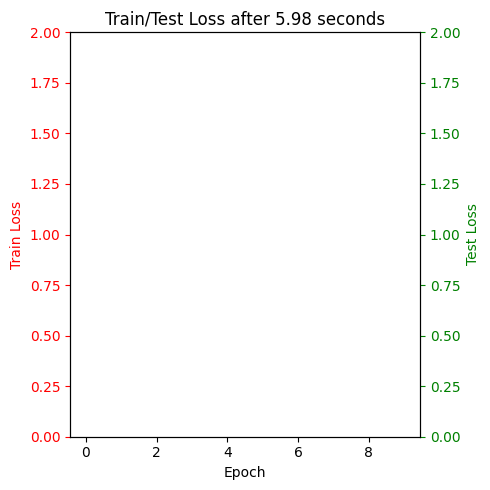

In [45]:
fig, ax1 = plt.subplots(figsize=(5, 5))
fontsize = 10
line_width = 0.5
y_axis_limit = int(max(losses['loss_train'] + losses['loss_test']) * 1.25)

ax1.plot(losses['epoch'], losses['loss_train'], color='red', label='Train Loss', linewidth=line_width + 1)
ax1.set_xlabel('Epoch', fontsize=fontsize)
ax1.set_ylabel('Train Loss', color='red', fontsize=fontsize)
ax1.tick_params('y', colors='red', labelsize=fontsize)
ax1.set_ylim(0, y_axis_limit) 

ax2 = ax1.twinx()
ax2.plot(losses['epoch'], losses['loss_test'], color='green', label='Test Loss', linewidth=line_width)
ax2.set_ylabel('Test Loss', color='green', fontsize=fontsize)
ax2.tick_params('y', colors='green', labelsize=fontsize)
ax2.set_ylim(0, y_axis_limit) 

plt.title(f'Train/Test Loss after {(losses["duration"]):.2f} seconds')
fig.tight_layout()
plt.show()

## Aftermath
### Loading and saving the model

We can utilize two functions to persist the model's result
- either putting everything to a pickel file or
- using PyTorch's state dic export feature

In [30]:
torch.save(obj = model.state_dict(), f = model_export)

In [31]:
model = GPTLanguageModel(vocab_size)
model.load_state_dict(torch.load(model_export))
model.to(device)

GPTLanguageModel(
  (token_embedding_table): Embedding(10, 128)
  (position_embedding_table): Embedding(8, 128)
  (blocks): Sequential(
    (0): TransformerBlock(
      (self_attention_layer): MultiHeadAttention(
        (heads): ModuleList(
          (0-3): 4 x Head(
            (linear_layer_keys): Linear(in_features=128, out_features=32, bias=False)
            (linear_layer_queries): Linear(in_features=128, out_features=32, bias=False)
            (linear_layer_values): Linear(in_features=128, out_features=32, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (projections): Linear(in_features=128, out_features=128, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (layer_normalisation_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feed_forward_layer): FeedForward(
        (linear_layer_stack): Sequential(
          (0): Linear(in_features=128, out_features=512, bias=True)
          (1): ReLU()
  

In [ ]:
with open('model-01.pkl', 'wb') as f:
    pickle.dump(model, f)
print('model saved')

In [ ]:
with open('model-01.pkl', 'rb') as f:
     model = pickle.load(f)

# Use the model
Finally, of course, we want to use the model. This simply generates new tokens for a given starting context. This is not ChatGPT, but at least it demonstrates the effect:

In [54]:
prompt = 'Hello Wo'
if len(prompt) < sequence_length:
  raise SystemError(f"Prompt length ({len(prompt)}) cannot be smaller than sequence length: {sequence_length}")
context = torch.tensor(encode(char_table, prompt), dtype=torch.long, device=device)

with torch.inference_mode():
  for iter in range(10):    
    generated_chars = decode(reverse_char_table, model.generate(context.unsqueeze(0), max_new_tokens = 30)[0].tolist())
    print(generated_chars)

Hello WolHeloHerrlloWlrle
rlddrl 
!H
l
Hello WoWWeoellre  r

!ldr
r odro reW

Hello Wo lld Wl!o 
lrrHrl
leeorHl!HHle
Hello Wor
r!eHlerdrH  dH  
leH ooo W


Hello WoWWr!errWd
roHdeo dHldderWeedll
Hello Woollo!!
HH erH!W Hlor !leddl
dd
Hello Worddr  ldHd!!lelHdH!ld
 
lrWrrl
Hello Wo
e rH !W 
ll oHrW !W orWl!r!
r
Hello Wood

eddrdWleorWe!H
Hede e!
Hll
Hello Wo
rHol
!!lW!ledHedeWeeoW  lo
ee


# Part 2 - Step By Step

<img style="float: right;" src="gfx/Folie1.png">

The following part will  look at the process inside the model, not the learning process. Meaning we are **not** going to deal with loss and optimizer. 

We will use a simple *text* containing 100 times the same chars: *ABCA*. 

First we need to encode it, simply using an integer char table.

In [55]:
data = 'ABCA' * 100

chars = sorted(list(set(''.join(data))))
vocab_size = len(chars)
char_table = {char:index for index,char in enumerate(chars)}
encoded_data = torch.tensor(encode(char_table = char_table, text = data), dtype=torch.long)

print(f'First 20 chars in our dataset: {data[:20]}')
print(f'Char table: {char_table}')
print(f'Vocabulary size is: {vocab_size}')

First 20 chars in our dataset: ABCAABCAABCAABCAABCA
Char table: {'A': 0, 'B': 1, 'C': 2}
Vocabulary size is: 3


Now we will take ```batch_size``` sequences of length ```sequence_length``` from random positions in the text. In this simple case this will result in **2 sequences** with a length of **4 chars** each. The output is a tensor with a shape of 2, 4 - 2 sequences, sequence length is 4:

In [56]:
sequence_length = 4 # tokens per block/sequence
batch_size = 2 # blocks per batch

random_block_start_indices = torch.randint(len(encoded_data) - sequence_length, (batch_size,))
            
X_batch = torch.stack([encoded_data[index:index + sequence_length] for index in random_block_start_indices])
X_batch = X_batch.to(device)
X_batch

tensor([[2, 0, 0, 1],
        [0, 1, 2, 0]], device='mps:0')

FWIFW: We skip the `y_batch` for now. For that we just need to shift the position of the `X_batch` by e.g. 1 position to the right.

Our first batch is ready. We could translate this back to readable chars, just to check what positions our previous function gave us:

In [58]:
print([''.join(list(char_table.keys())[idx] for idx in sequence) for sequence in X_batch.cpu().numpy()])

['CAAB', 'ABCA']


<img style="float: right;" src="gfx/Folie2.png">

Now let's create the token embeddings, which is "simply" a float representation of length `embedding_size` for each char. As you can see, this increases the shape of or tensor: We have 2 sequences with a sequence length of 4 and each having 3 embeddings. If you read it from top to bottom, you get your letters/tokens for each sequence:

In [59]:
embedding_size = 3

token_embeddings_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size).to(device)
X_token_embeddings = token_embeddings_table(X_batch)
X_token_embeddings

tensor([[[ 0.4070,  0.2609,  0.3285],
         [-0.8823,  0.3972,  0.1231],
         [-0.8823,  0.3972,  0.1231],
         [ 0.5862,  0.2738, -0.7513]],

        [[-0.8823,  0.3972,  0.1231],
         [ 0.5862,  0.2738, -0.7513],
         [ 0.4070,  0.2609,  0.3285],
         [-0.8823,  0.3972,  0.1231]]], device='mps:0',
       grad_fn=<EmbeddingBackward0>)

The position embeddings works basically the same. This time we use a vector representing each position of the sequence. 

In [60]:
position_embeddings_table = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_size).to(device)
positions = torch.arange(sequence_length, device = device)
positions

tensor([0, 1, 2, 3], device='mps:0')

And then we map our sequence to this position embeddings table. Now every position is represented by a vector with the length of `embedding_size`. Now the tensor consists of only one matrix. Apparently, because this tensor just represents the positions from 1 to 4:

In [61]:
X_position_embeddings = position_embeddings_table(positions)
X_position_embeddings

tensor([[-0.2754, -0.0690, -1.2826],
        [ 0.5533,  0.1064,  1.7657],
        [-0.9466,  1.8032,  1.3748],
        [ 0.0000,  0.0000,  0.0000]], device='mps:0',
       grad_fn=<EmbeddingBackward0>)

<img style="float: right;" src="gfx/Folie3.png">

Finally we add up both embedding/matrices that we can send right away to into our Model. You still can see our tokens (aka chars) from top to botton, each one represented by a vector of floats:

In [62]:
X_embeddings = X_token_embeddings + X_position_embeddings
X_embeddings

tensor([[[ 0.1316,  0.1919, -0.9541],
         [-0.3290,  0.5036,  1.8888],
         [-1.8289,  2.2004,  1.4979],
         [ 0.5862,  0.2738, -0.7513]],

        [[-1.1577,  0.3283, -1.1595],
         [ 1.1395,  0.3802,  1.0144],
         [-0.5396,  2.0641,  1.7033],
         [-0.8823,  0.3972,  0.1231]]], device='mps:0', grad_fn=<AddBackward0>)

<img style="float: right;" src="gfx/Folie4.png">

Wen the embeddings arrive in the Transformer block, they go straight to the first Multihead-Attention-Module where we first calculate `keys` and `queries` using `LinearLayers`. Every embedding is now represented by a vector, where the length is defined by `attention_head_size`. If you look closer, you may still recognize our tokens from top to bottom ;)

While `keys` and `queries` serve a different purpose, the both come from the same mathematical background: a Linear Layer (with not bias).

In [72]:
# attention_head_size is set locally for training purposes, if we had multiple heads, we'd set this to embedding_size / num_heads
attention_head_size = 1

linear_layer_keys = nn.Linear(in_features=embedding_size, out_features=attention_head_size, bias=False).to(device)
linear_layer_queries = nn.Linear(in_features=embedding_size, out_features=attention_head_size, bias=False).to(device)
keys = linear_layer_keys(X_embeddings)
queries = linear_layer_queries(X_embeddings)
print(keys)
print(queries)

tensor([[[0.1988],
         [0.0080],
         [0.7045],
         [0.2537]],

        [[0.1745],
         [0.1656],
         [0.7288],
         [0.0960]]], device='mps:0', grad_fn=<LinearBackward0>)
tensor([[[ 0.0341],
         [ 0.4429],
         [ 2.2007],
         [-0.1808]],

        [[ 0.8383],
         [-0.4488],
         [ 1.3965],
         [ 0.7109]]], device='mps:0', grad_fn=<LinearBackward0>)


This step is called "scaled dot-product". Before we can multiply queries and keys, keys have to be transposed. Then we apply a "scaling" using square root. The result is now some kind of attention score representing, how our input tokens "attend" to each other. 

In [70]:
scaled_attention_scores = queries @ keys.transpose(-2,-1) * keys.shape[-1] ** -0.5
scaled_attention_scores

tensor([[[-0.1556,  0.2085, -0.2660, -0.0577],
         [ 0.2727, -0.3654,  0.4661,  0.1011],
         [ 0.5263, -0.7051,  0.8996,  0.1951],
         [-0.2591,  0.3471, -0.4428, -0.0960]],

        [[ 0.4145, -0.3154,  0.0124,  0.1627],
         [-0.5585,  0.4249, -0.0167, -0.2191],
         [ 0.5605, -0.4264,  0.0168,  0.2199],
         [ 0.5943, -0.4521,  0.0178,  0.2332]]], device='mps:0',
       grad_fn=<MulBackward0>)

<img style="float: right;" src="gfx/Folie5.png">

But we don't want them to attend to "future" tokens, that's why we need to drop some attention scores. To achieve that we use some PyTorch magic: The triangular matrix is a triangular made of 1s:

In [77]:
triangular_matrix= torch.tril(torch.ones(sequence_length, sequence_length)).to(device)
triangular_matrix

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]], device='mps:0')

<img style="float: right;" src="gfx/Folie6.png">

Now we mask the attention scores using this triangular matrix. This way a token  only attends to itself and all previous tokens:

In [78]:
causal_attention_scores = scaled_attention_scores.masked_fill(triangular_matrix[:sequence_length, :sequence_length] == 0, float('-inf'))
causal_attention_scores

tensor([[[-0.1556,    -inf,    -inf,    -inf],
         [ 0.2727, -0.3654,    -inf,    -inf],
         [ 0.5263, -0.7051,  0.8996,    -inf],
         [-0.2591,  0.3471, -0.4428, -0.0960]],

        [[ 0.4145,    -inf,    -inf,    -inf],
         [-0.5585,  0.4249,    -inf,    -inf],
         [ 0.5605, -0.4264,  0.0168,    -inf],
         [ 0.5943, -0.4521,  0.0178,  0.2332]]], device='mps:0',
       grad_fn=<MaskedFillBackward0>)

And some housekeeping. Softmax results in actual probabilities:

In [79]:
weights = torch.softmax(causal_attention_scores, dim=-1) # (B, T, T)
weights

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.6543, 0.3457, 0.0000, 0.0000],
         [0.3644, 0.1064, 0.5293, 0.0000],
         [0.2065, 0.3786, 0.1718, 0.2431]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2722, 0.7278, 0.0000, 0.0000],
         [0.5119, 0.1908, 0.2972, 0.0000],
         [0.3831, 0.1346, 0.2153, 0.2670]]], device='mps:0',
       grad_fn=<SoftmaxBackward0>)

<img style="float: right;" src="gfx/Folie7.png">

"Dropping nodes" is a common practice to prevent overfitting:

In [89]:
dropout_rate = 0.2

dropout = nn.Dropout(dropout_rate)
weights = dropout(weights)
weights

tensor([[[0.0000, 0.0000, 0.0000, 0.0000],
         [1.0224, 0.5401, 0.0000, 0.0000],
         [0.5693, 0.1662, 0.0000, 0.0000],
         [0.3227, 0.5916, 0.2685, 0.3798]],

        [[1.5625, 0.0000, 0.0000, 0.0000],
         [0.4254, 1.1371, 0.0000, 0.0000],
         [0.7999, 0.2982, 0.0000, 0.0000],
         [0.5987, 0.0000, 0.0000, 0.4172]]], device='mps:0',
       grad_fn=<MulBackward0>)

<img style="float: right;" src="gfx/Folie8.png">

Now, again using a "simple" Linear Layer without biases, we calculate values and multiply them with our weights. This results in weighted values or better: attention scores:

In [100]:
linear_layer_values = nn.Linear(in_features=embedding_size, out_features=attention_head_size, bias=False).to(device)
values = linear_layer_values(X_embeddings)
attention_scores = weights @ values
print(attention_scores)

tensor([[[ 0.0000],
         [-0.1649],
         [-0.1066],
         [-0.1014]],

        [[-0.4705],
         [ 0.1984],
         [-0.1553],
         [-0.2430]]], device='mps:0', grad_fn=<UnsafeViewBackward0>)


<img style="float: right;" src="gfx/Folie10.png">

In the next step, within the MultiHeadAttention-Class, the weighted values of each head will now be **concatenated** and another dropout will be applied. We can skip this, as we only simulate one head here. The final result will be send back to the TransformerBlock, where it will be processed further. First step is a Normalisation Layer:

In [99]:
normalisation_layer_1 = nn.LayerNorm(embedding_size).to(device)
normalised_attention_scores = normalisation_layer_1(X_embeddings + attention_scores)

print(normalised_attention_scores)

tensor([[[ 0.6491,  0.7635, -1.4127],
         [-1.1116, -0.2014,  1.3129],
         [-1.3952,  0.8975,  0.4978],
         [ 0.9627,  0.4159, -1.3785]],

        [[-0.7058,  1.4142, -0.7084],
         [ 0.8869, -1.3974,  0.5105],
         [-1.4026,  0.8579,  0.5447],
         [-1.3846,  0.9415,  0.4431]]], device='mps:0',
       grad_fn=<NativeLayerNormBackward0>)


<img style="float: right;" src="gfx/Folie11.png">

And here comes the second important part of the Model: The FeedForwardLayer. Again, this is basically just a Linear Layer, a ReLu-Layer (remember part 02, binary classification?), another Linear Layer and again, a dropout layer. While the multi-head attention calculates relationships, this part refines individual characteristics:

In [98]:
feed_forward_layer = FeedForward().to(device)
normalisation_layer_2 = nn.LayerNorm(embedding_size).to(device)

refined_attention_scores = feed_forward_layer(normalised_attention_scores) # refine individual characteristics
final_attention_scores = normalisation_layer_2(refined_attention_scores + normalised_attention_scores) # residual connection to mitigate the vanishing gradient

print(final_attention_scores)

tensor([[[ 0.4651,  0.9240, -1.3892],
         [-1.3505,  0.3116,  1.0388],
         [-1.3701,  0.9884,  0.3817],
         [ 0.7511,  0.6622, -1.4133]],

        [[-0.8311,  1.4065, -0.5754],
         [ 0.9631, -1.3784,  0.4153],
         [-1.4033,  0.8532,  0.5501],
         [-1.3939,  0.9037,  0.4902]]], device='mps:0',
       grad_fn=<NativeLayerNormBackward0>)


<img style="float: right;" src="gfx/Folie13.png">

Done that, we do the same same thing again in all the other Transformer Blocks. 